<a href="https://colab.research.google.com/github/RenneeWang/DQN_and_DRQN/blob/main/TFDF_Creamy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data & Environment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns

In [2]:
!pip install tensorflow_decision_forests
!pip install wurlitzer

     |████████████████████████████████| 6.3 MB 2.5 MB/s 


In [3]:
import tensorflow_decision_forests as tfdf

import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [4]:
from copy import deepcopy

In [5]:
# labels
df = pd.read_excel('/content/olfactory_labels_1018.xlsx')
df.head()

,chemical_name,cas,smiles,leffingwell,fema,fema no,sum,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,pungent,onion,dairy,...,overripe fruity,organic,oats,nutmeg,mocha,menthol,marshmallow,linoleum,lily,licorice,lettuce,lemon peel,lactone,kiwi,iron scorch,harsh,greenery,gravy,glue,fir,fabric,eucalyptol,dull,dry fish,dill,dandelion,cresol,cotton,cooked,contact glue,cereal,carbide,burnt matches,brown sugar,box tree,bell pepper,beeswaxy,basil,baked,bayberry
0,Acetal,105-57-7,CCOC(C)OCC,"['green', 'fruity', 'alcoholic']","Creamy, Fruit, Pleasant, Tropical Fruit",2002.0,9,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,"['green', 'leafy', 'floral']",Green Leaf,2004.0,5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,"['hay', 'floral', 'sweet']",Bitter,2005.0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,"['fruity', 'ethereal']",0,2007.0,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Acetoin,513-86-0,CC(C(=O)C)O,"['creamy', 'buttery']","Butter, Creamy, Green Pepper",2008.0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [185]:
MACCS = pd.read_csv('/content/MACCS_1018.csv',encoding="utf-8")
MACCS.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_127,maccs_128,maccs_129,maccs_130,maccs_131,maccs_132,maccs_133,maccs_134,maccs_135,maccs_136,maccs_137,maccs_138,maccs_139,maccs_140,maccs_141,maccs_142,maccs_143,maccs_144,maccs_145,maccs_146,maccs_147,maccs_148,maccs_149,maccs_150,maccs_151,maccs_152,maccs_153,maccs_154,maccs_155,maccs_156,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,Acetal,105-57-7,CCOC(C)OCC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,1,1,1,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,0,0
4,Acetoin,513-86-0,CC(C(=O)C)O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0


In [ ]:
label = "creamy"

classes = MACCS_creamy[label].unique().tolist()
print(f"Label classes: {classes}")

MACCS_creamy[label] = MACCS_creamy[label].map(classes.index)

In [186]:
for n in MACCS.columns[3:]:
  classes = MACCS[n].unique().tolist()
  MACCS[n] = MACCS[n].map(classes.index)
MACCS.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_127,maccs_128,maccs_129,maccs_130,maccs_131,maccs_132,maccs_133,maccs_134,maccs_135,maccs_136,maccs_137,maccs_138,maccs_139,maccs_140,maccs_141,maccs_142,maccs_143,maccs_144,maccs_145,maccs_146,maccs_147,maccs_148,maccs_149,maccs_150,maccs_151,maccs_152,maccs_153,maccs_154,maccs_155,maccs_156,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,Acetal,105-57-7,CCOC(C)OCC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Acetoin,513-86-0,CC(C(=O)C)O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
def encoding(x):
    encode = ['no','yes']
    return encode[x]

for n in MACCS.columns[3:]:
    MACCS[n] = MACCS[n].map(encoding)
MACCS.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_127,maccs_128,maccs_129,maccs_130,maccs_131,maccs_132,maccs_133,maccs_134,maccs_135,maccs_136,maccs_137,maccs_138,maccs_139,maccs_140,maccs_141,maccs_142,maccs_143,maccs_144,maccs_145,maccs_146,maccs_147,maccs_148,maccs_149,maccs_150,maccs_151,maccs_152,maccs_153,maccs_154,maccs_155,maccs_156,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,Acetal,105-57-7,CCOC(C)OCC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,no,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,yes,no,yes,yes,no,no,no,yes,no,no
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,yes,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,yes,no,yes,no,no,no,yes,no,yes,no,yes,no,yes,yes,no,yes,yes,yes,yes,no
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,yes,no,yes,no,no,yes,no,yes,yes,no,yes,yes,yes,yes,no
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,yes,no,no,no,yes,no,yes,no,yes,yes,no,no,no,no,yes,no,no,yes,no,no,yes,yes,yes,yes,no,yes,no,yes,yes,no,no,no,yes,no,no
4,Acetoin,513-86-0,CC(C(=O)C)O,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,yes,no,no,yes,no,yes,no,no,yes,no,yes,yes,no,no,no,yes,no,no


In [8]:
F = pd.read_csv('/content/features_1024.csv')
F.head()

,chemical_name,cas,smiles,main_length,ring_num,main_C,main_S,main_N,main_O,main_I,main_double_C,main_double_N,main_double_S,main_double_O,num_side,max_side,min_side,side_C,side_S,side_N,side_O,side_I,side_double_C,side_double_N,side_double_S,side_double_O,triple_C,triple_N,Cl,Br,F,carboxyl,keto,carbonyl,hydroxy
0,Acetal,105-57-7,CCOC(C)OCC,7,0.0,5,0,0,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,14,1.0,12,0,0,2,0,3,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,8,1.0,7,0,0,1,0,2,0,0,0,2,2,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,12,0.0,9,0,0,3,0,0,0,0,0,3,5,1,3,0,0,4,0,0,0,0,3,0,0,0,0,0,1,1,3,0
4,Acetoin,513-86-0,CC(C(=O)C)O,3,0.0,2,0,0,1,0,0,0,0,0,1,3,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [9]:
MACCS.shape, df.shape, F.shape

((3736, 170), (3736, 223), (3736, 35))

In [10]:
Top30 = list(df.columns[7:37])
Top30

['fruity',
 'green',
 'sweet',
 'floral',
 'fatty',
 'herbal',
 'sulfurous',
 'spicy',
 'nutty',
 'apple',
 'fresh',
 'waxy',
 'woody',
 'savory',
 'citrus',
 'meaty',
 'roasted',
 'oily',
 'tropical',
 'ethereal',
 'earthy',
 'rose',
 'winey',
 'balsamic',
 'caramellic',
 'vegetable',
 'mint',
 'pineapple',
 'cheesy',
 'burnt']

In [187]:
MACCS_creamy = pd.merge(MACCS,df[['chemical_name','cas','smiles']+Top30+['creamy']],on=['chemical_name','cas','smiles'],how='inner')
MACCS_creamy.shape

(3736, 201)

In [188]:
for n in Top30:
  classes = MACCS_creamy[n].unique().tolist()
  MACCS_creamy[n] = MACCS_creamy[n].map(classes.index)
MACCS_creamy.head()

,chemical_name,cas,smiles,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,maccs_10,maccs_11,maccs_12,maccs_13,maccs_14,maccs_15,maccs_16,maccs_17,maccs_18,maccs_19,maccs_20,maccs_21,maccs_22,maccs_23,maccs_24,maccs_25,maccs_26,maccs_27,maccs_28,maccs_29,maccs_30,maccs_31,maccs_32,maccs_33,maccs_34,maccs_35,maccs_36,...,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,creamy
0,Acetal,105-57-7,CCOC(C)OCC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1
4,Acetoin,513-86-0,CC(C(=O)C)O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [15]:
F_creamy = pd.merge(F,df[['chemical_name','cas','smiles']+Top30+['creamy']],on=['chemical_name','cas','smiles'],how='left')
F_creamy.shape

(3736, 66)

In [16]:
for n in Top30:
    F_creamy[n] = F_creamy[n].map(encoding)
F_creamy.head()

,chemical_name,cas,smiles,main_length,ring_num,main_C,main_S,main_N,main_O,main_I,main_double_C,main_double_N,main_double_S,main_double_O,num_side,max_side,min_side,side_C,side_S,side_N,side_O,side_I,side_double_C,side_double_N,side_double_S,side_double_O,triple_C,triple_N,Cl,Br,F,carboxyl,keto,carbonyl,hydroxy,fruity,green,sweet,floral,fatty,herbal,sulfurous,spicy,nutty,apple,fresh,waxy,woody,savory,citrus,meaty,roasted,oily,tropical,ethereal,earthy,rose,winey,balsamic,caramellic,vegetable,mint,pineapple,cheesy,burnt,creamy
0,Acetal,105-57-7,CCOC(C)OCC,7,0.0,5,0,0,2,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,yes,yes,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,1
1,Acetaldehyde phenethyl propyl acetal,7493-57-4,CCCOC(C)OCCC1=CC=CC=C1,14,1.0,12,0,0,2,0,3,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,no,yes,no,yes,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
2,Acetanisole,100-06-1,CC(=O)C1=CC=C(C=C1)OC,8,1.0,7,0,0,1,0,2,0,0,0,2,2,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,no,no,yes,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,0
3,Triacetin,102-76-1,CC(=O)OCC(COC(=O)C)OC(=O)C,12,0.0,9,0,0,3,0,0,0,0,0,3,5,1,3,0,0,4,0,0,0,0,3,0,0,0,0,0,1,1,3,0,yes,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,1
4,Acetoin,513-86-0,CC(C(=O)C)O,3,0.0,2,0,0,1,0,0,0,0,0,1,3,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,no,no,no,no,no,no,no,no,no,no,no,no,no,no,yes,no,1


In [18]:
MF_creamy = pd.merge(MACCS,F_creamy,on=['chemical_name','cas','smiles'])
MF_creamy.shape

(3736, 233)

In [22]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
    """Splits a panda dataframe in two."""
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]



# MACCS

In [189]:
label = "creamy"

classes = MACCS_creamy[label].unique().tolist()
print(f"Label classes: {classes}")

MACCS_creamy[label] = MACCS_creamy[label].map(classes.index)

Label classes: [1, 0]


In [190]:
train_ds_pd, test_ds_pd = split_dataset(MACCS_creamy.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2641 examples in training, 1095 examples for testing.


In [191]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='creamy')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='creamy')

In [192]:
# %set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [193]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=train_ds)

42/42 [==============================] - 3s 19ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 42
[INFO kernel.cc:393] Number of examples: 2641
[INFO kernel.cc:769] Dataset:
Number of records: 2641
Number of columns: 198

Number of columns by type:
	NUMERICAL: 197 (99.4949%)
	CATEGORICAL: 1 (0.505051%)

Columns:

NUMERICAL: 197 (99.4949%)
	0: "apple" NUMERICAL mean:0.0783794 min:0 max:1 sd:0.268768
	1: "balsamic" NUMERICAL mean:0.0488451 min:0 max:1 sd:0.215544
	2: "burnt" NUMERICAL mean:0.039379 min:0 max:1 sd:0.194495
	3: "caramellic" NUMERICAL mean:0.0454373 min:0 max:1 sd:0.208261
	4: "cheesy" NUMERICAL mean:0.0408936 min:0 max:1 sd:0.198044
	5: "citrus" NUMERICAL mean:0.0768648 min:0 max:1 sd:0.266377
	6: "earthy" NUMERICAL mean:0.057554 min:0 max:1 sd:0.232898
	7: "ethereal" NUMERICAL mean:0.0613404 min:0 max:1 sd:0.239954
	8: "fatty" NUMERICAL mean:0.12571 min:0 max:1 sd:0.331522
	9: "floral" NUMERICAL mean:0.208633 min:0 max:1 sd:0.40

In [194]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

18/18 [==============================] - 2s 20ms/step - loss: 0.0000e+00 - accuracy: 0.9644 - auc: 0.8631 - recall: 0.9971 - precision: 0.9668

loss: 0.0000
accuracy: 0.9644
auc: 0.8631
recall: 0.9971
precision: 0.9668


In [195]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

In [139]:
inspector = model_1.make_inspector()

In [140]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 NUM_AS_ROOT
	 MEAN_MIN_DEPTH
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 MEAN_DECREASE_IN_ACCURACY
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 NUM_NODES
	 SUM_SCORE


In [141]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [142]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [143]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [144]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(sweet, 4, 191)",0.003010,sweet,4,191
1,"(maccs_143, 4, 64)",0.001505,maccs_143,4,64
2,"(maccs_127, 4, 46)",0.001129,maccs_127,4,46
3,"(maccs_154, 4, 76)",0.001129,maccs_154,4,76
4,"(maccs_136, 4, 56)",0.001129,maccs_136,4,56


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

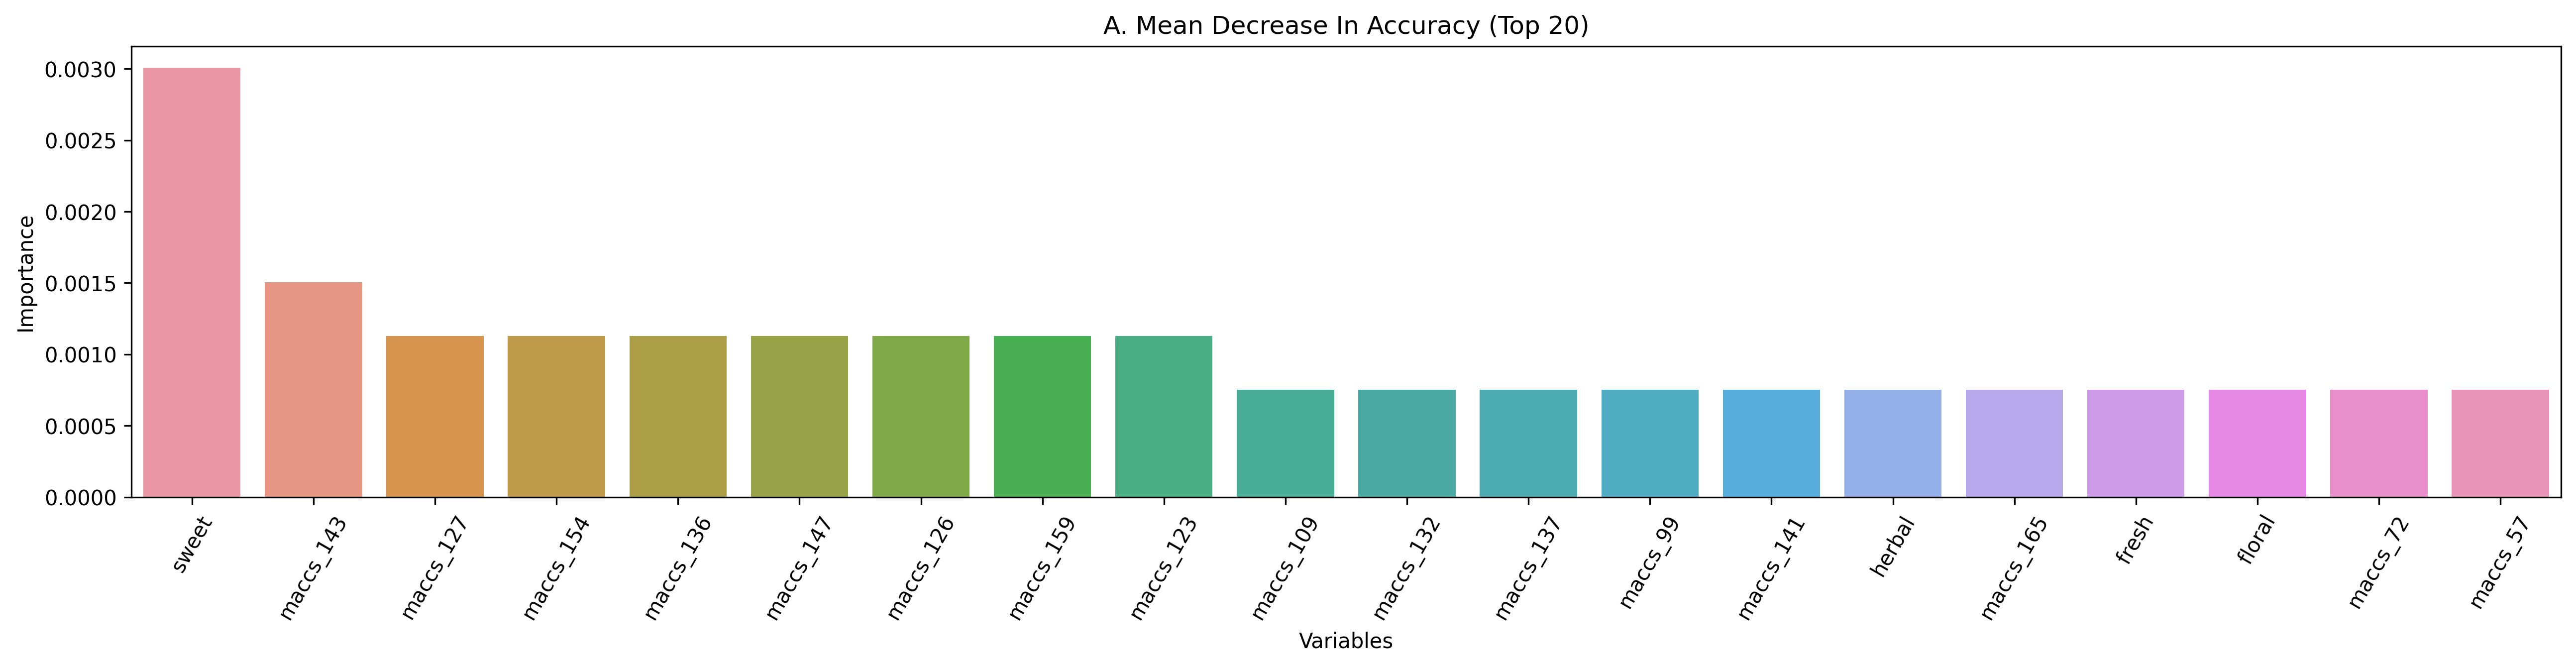

In [145]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [146]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [147]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(maccs_72, 4, 151)",0.028886,maccs_72,4,151
1,"(maccs_115, 4, 33)",0.017634,maccs_115,4,33
2,"(oily, 4, 184)",0.017413,oily,4,184
3,"(cheesy, 4, 4)",0.008103,cheesy,4,4
4,"(maccs_129, 4, 48)",0.007621,maccs_129,4,48


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

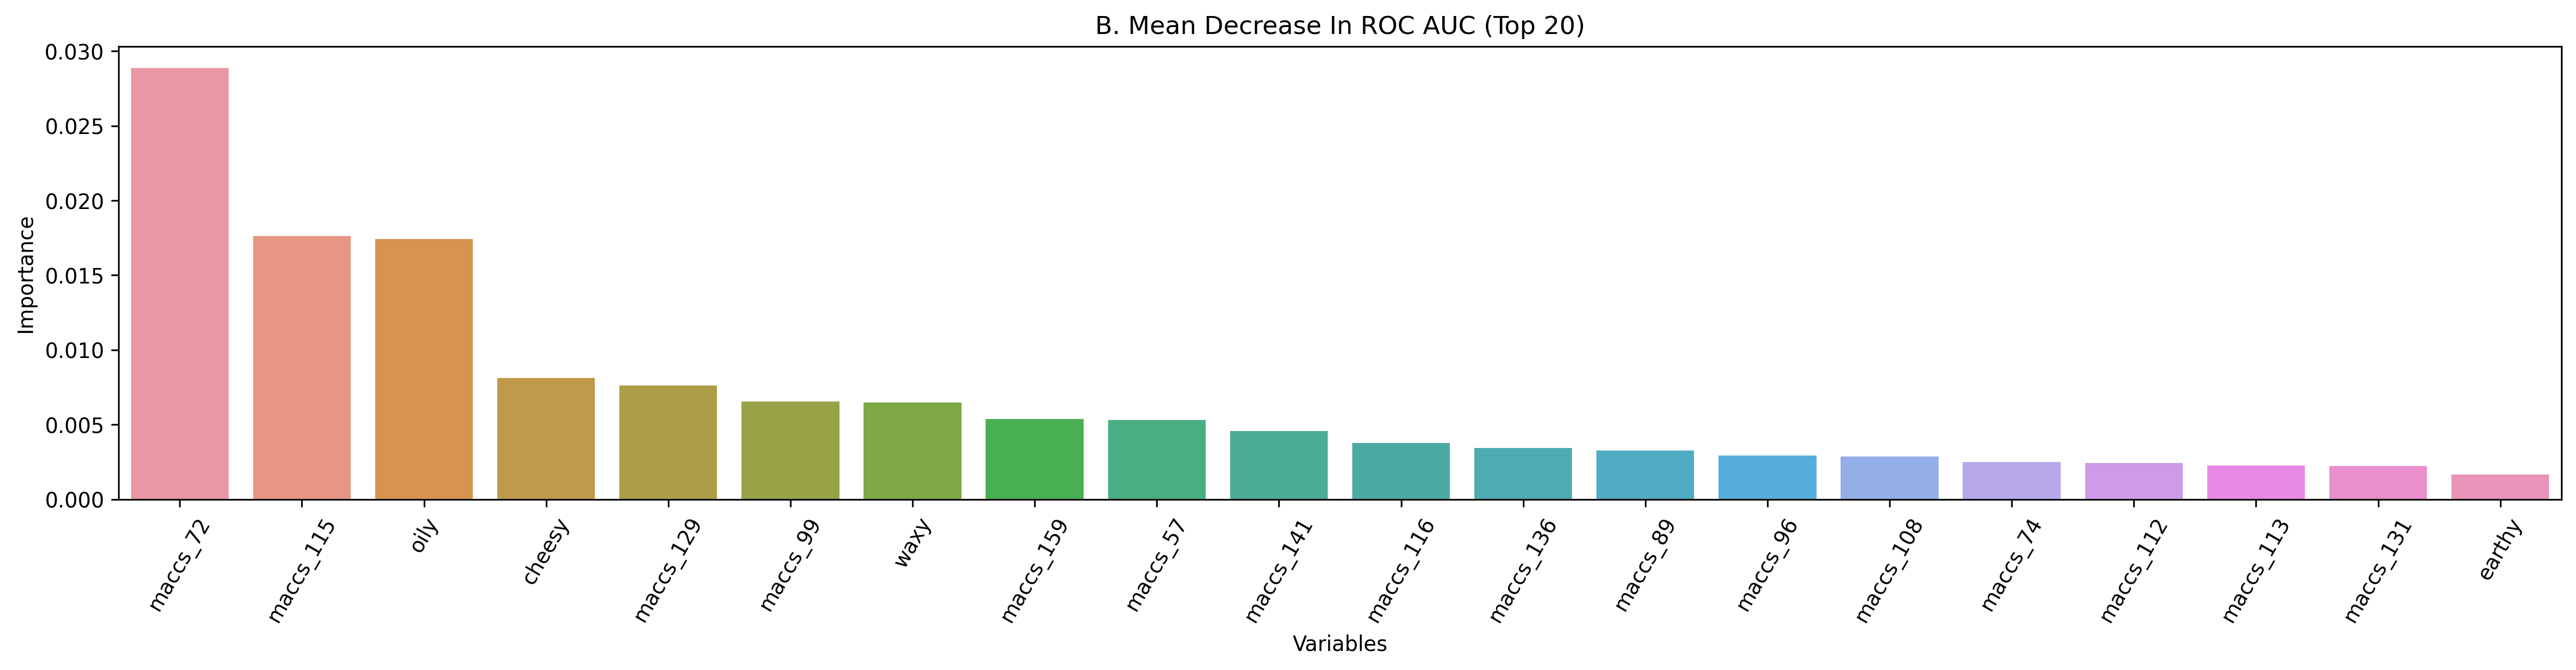

In [148]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [149]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [150]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(sweet, 4, 191)",28.0,sweet,4,191
1,"(maccs_57, 4, 134)",24.0,maccs_57,4,134
2,"(maccs_72, 4, 151)",21.0,maccs_72,4,151
3,"(maccs_159, 4, 81)",20.0,maccs_159,4,81
4,"(maccs_143, 4, 64)",15.0,maccs_143,4,64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

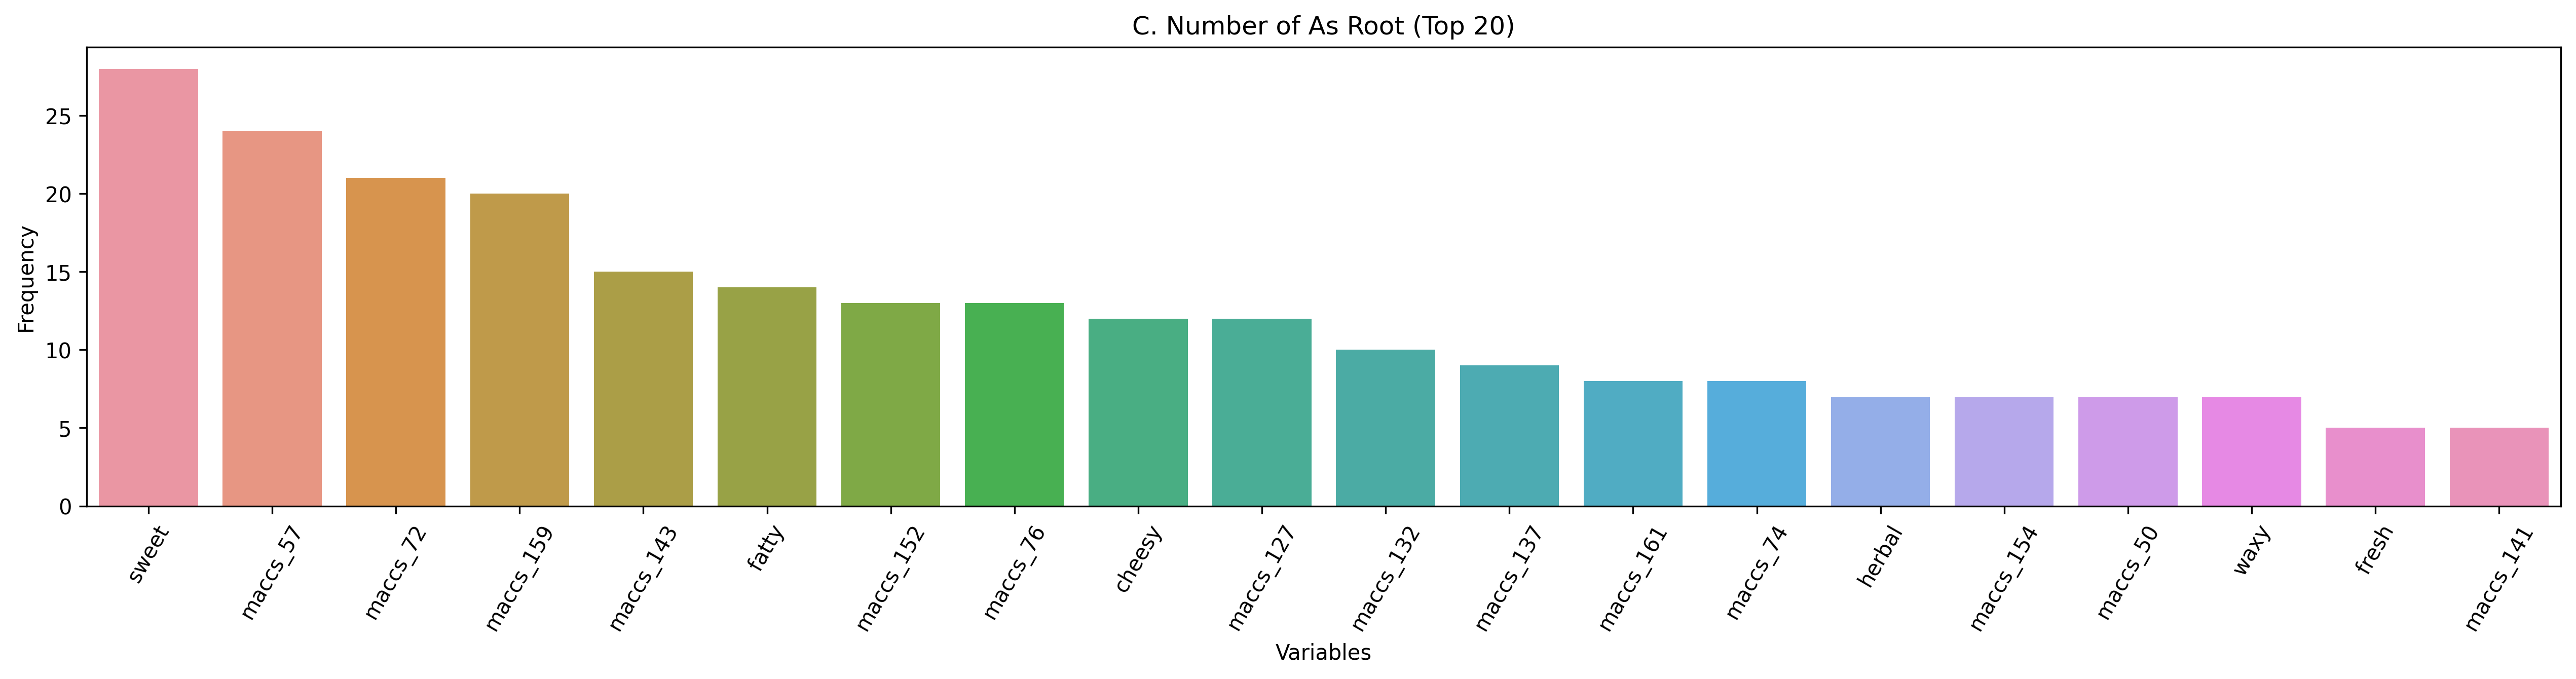

In [151]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [152]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [153]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(sweet, 4, 191)",4629.816182,sweet,4,191
1,"(maccs_72, 4, 151)",3398.110913,maccs_72,4,151
2,"(fatty, 4, 8)",2897.922478,fatty,4,8
3,"(waxy, 4, 194)",2415.809947,waxy,4,194
4,"(maccs_57, 4, 134)",2391.722032,maccs_57,4,134


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

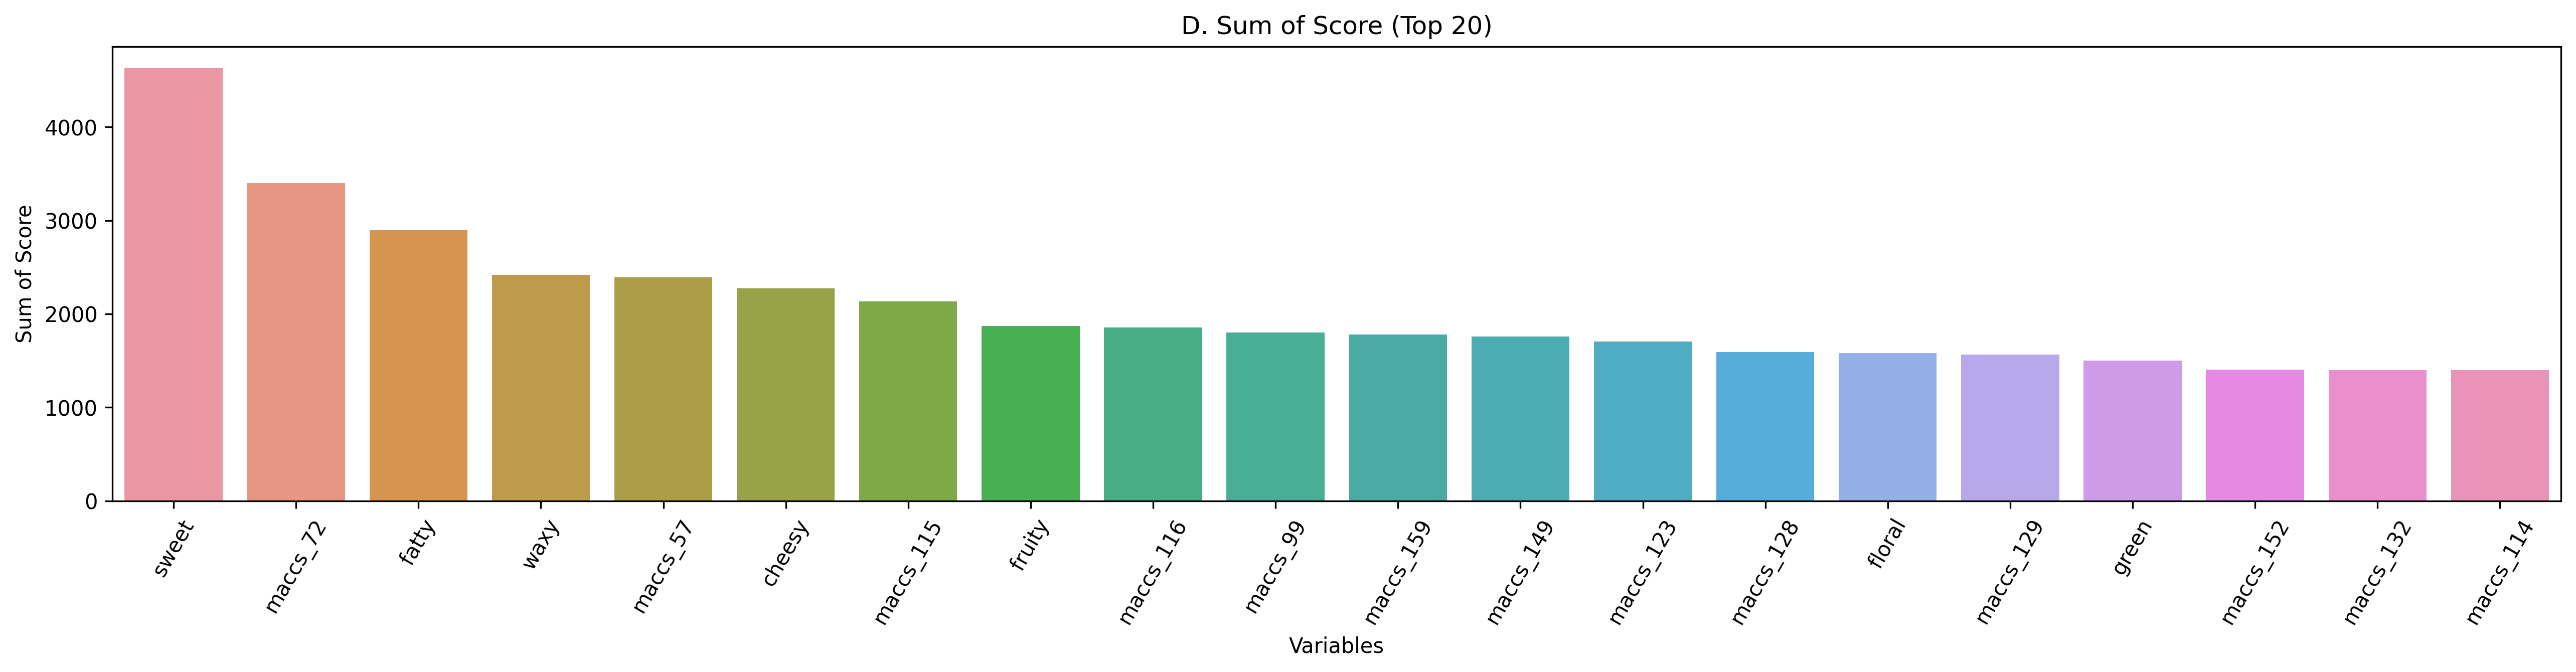

In [154]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [155]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [156]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(sweet, 4, 191)",0.003010,sweet,4,191,175,"(sweet, 4, 191)",-0.003165,0.0,"(sweet, 4, 191)",28.0,0.0,"(sweet, 4, 191)",4629.816182
1,1,"(maccs_143, 4, 64)",0.001505,maccs_143,4,64,184,"(maccs_143, 4, 64)",-0.005050,4.0,"(maccs_143, 4, 64)",15.0,25.0,"(maccs_143, 4, 64)",1253.636754
2,2,"(maccs_127, 4, 46)",0.001129,maccs_127,4,46,196,"(maccs_127, 4, 46)",-0.020330,9.0,"(maccs_127, 4, 46)",12.0,26.0,"(maccs_127, 4, 46)",1244.701772
3,3,"(maccs_154, 4, 76)",0.001129,maccs_154,4,76,24,"(maccs_154, 4, 76)",0.001218,15.0,"(maccs_154, 4, 76)",7.0,20.0,"(maccs_154, 4, 76)",1310.716200
4,4,"(maccs_136, 4, 56)",0.001129,maccs_136,4,56,11,"(maccs_136, 4, 56)",0.003426,21.0,"(maccs_136, 4, 56)",4.0,21.0,"(maccs_136, 4, 56)",1289.965245


In [157]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [158]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(10)

,variable,ranking
18,maccs_72,21.0
7,maccs_159,27.0
19,maccs_57,32.0
35,maccs_115,42.0
4,maccs_136,57.0
5,maccs_147,61.0
3,maccs_154,62.0
13,maccs_141,64.0
24,maccs_89,69.0
12,maccs_99,72.0


# Fragment

In [159]:
label = "creamy"

classes = F_creamy[label].unique().tolist()
print(f"Label classes: {classes}")

F_creamy[label] = F_creamy[label].map(classes.index)

Label classes: [0, 1]


In [160]:
train_ds_pd, test_ds_pd = split_dataset(F_creamy.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2618 examples in training, 1118 examples for testing.


In [161]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='creamy')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='creamy')

In [162]:
# %set_cell_height 300

# Specify the model.
model_2 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_2.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [163]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=train_ds)

41/41 [==============================] - 1s 8ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 41
[INFO kernel.cc:393] Number of examples: 2618
[INFO kernel.cc:769] Dataset:
Number of records: 2618
Number of columns: 63

Number of columns by type:
	NUMERICAL: 32 (50.7937%)
	CATEGORICAL: 31 (49.2063%)

Columns:

NUMERICAL: 32 (50.7937%)
	0: "Br" NUMERICAL mean:0 min:0 max:0 sd:0
	1: "Cl" NUMERICAL mean:0.00114591 min:0 max:3 sd:0.058621
	2: "F" NUMERICAL mean:0 min:0 max:0 sd:0
	7: "carbonyl" NUMERICAL mean:0.592819 min:0 max:5 sd:0.619256
	8: "carboxyl" NUMERICAL mean:0.255157 min:0 max:3 sd:0.451445
	19: "hydroxy" NUMERICAL mean:0.25974 min:0 max:2 sd:0.440231
	20: "keto" NUMERICAL mean:0.291444 min:0 max:3 sd:0.543251
	21: "main_C" NUMERICAL mean:7.88999 min:1 max:23 sd:3.62585
	22: "main_I" NUMERICAL mean:0 min:0 max:0 sd:0
	23: "main_N" NUMERICAL mean:0.0977846 min:0 max:3 sd:0.344645
	24: "main_O" NUMERICAL mean:0.849121 min:0 max:6 sd:0

In [164]:
evaluation = model_2.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

18/18 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.9732 - auc: 0.8276 - recall: 1.0000 - precision: 0.9731

loss: 0.0000
accuracy: 0.9732
auc: 0.8276
recall: 1.0000
precision: 0.9731


In [165]:
inspector = model_2.make_inspector()

In [166]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 MEAN_DECREASE_IN_ACCURACY
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS
	 NUM_NODES
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS


In [167]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [168]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [169]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [170]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(main_length, 1, 30)",0.000764,main_length,1,30
1,"(num_side, 1, 35)",0.000382,num_side,1,35
2,"(keto, 1, 20)",0.000382,keto,1,20
3,"(fruity, 4, 16)",0.000382,fruity,4,16
4,"(carbonyl, 1, 7)",0.000382,carbonyl,1,7


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

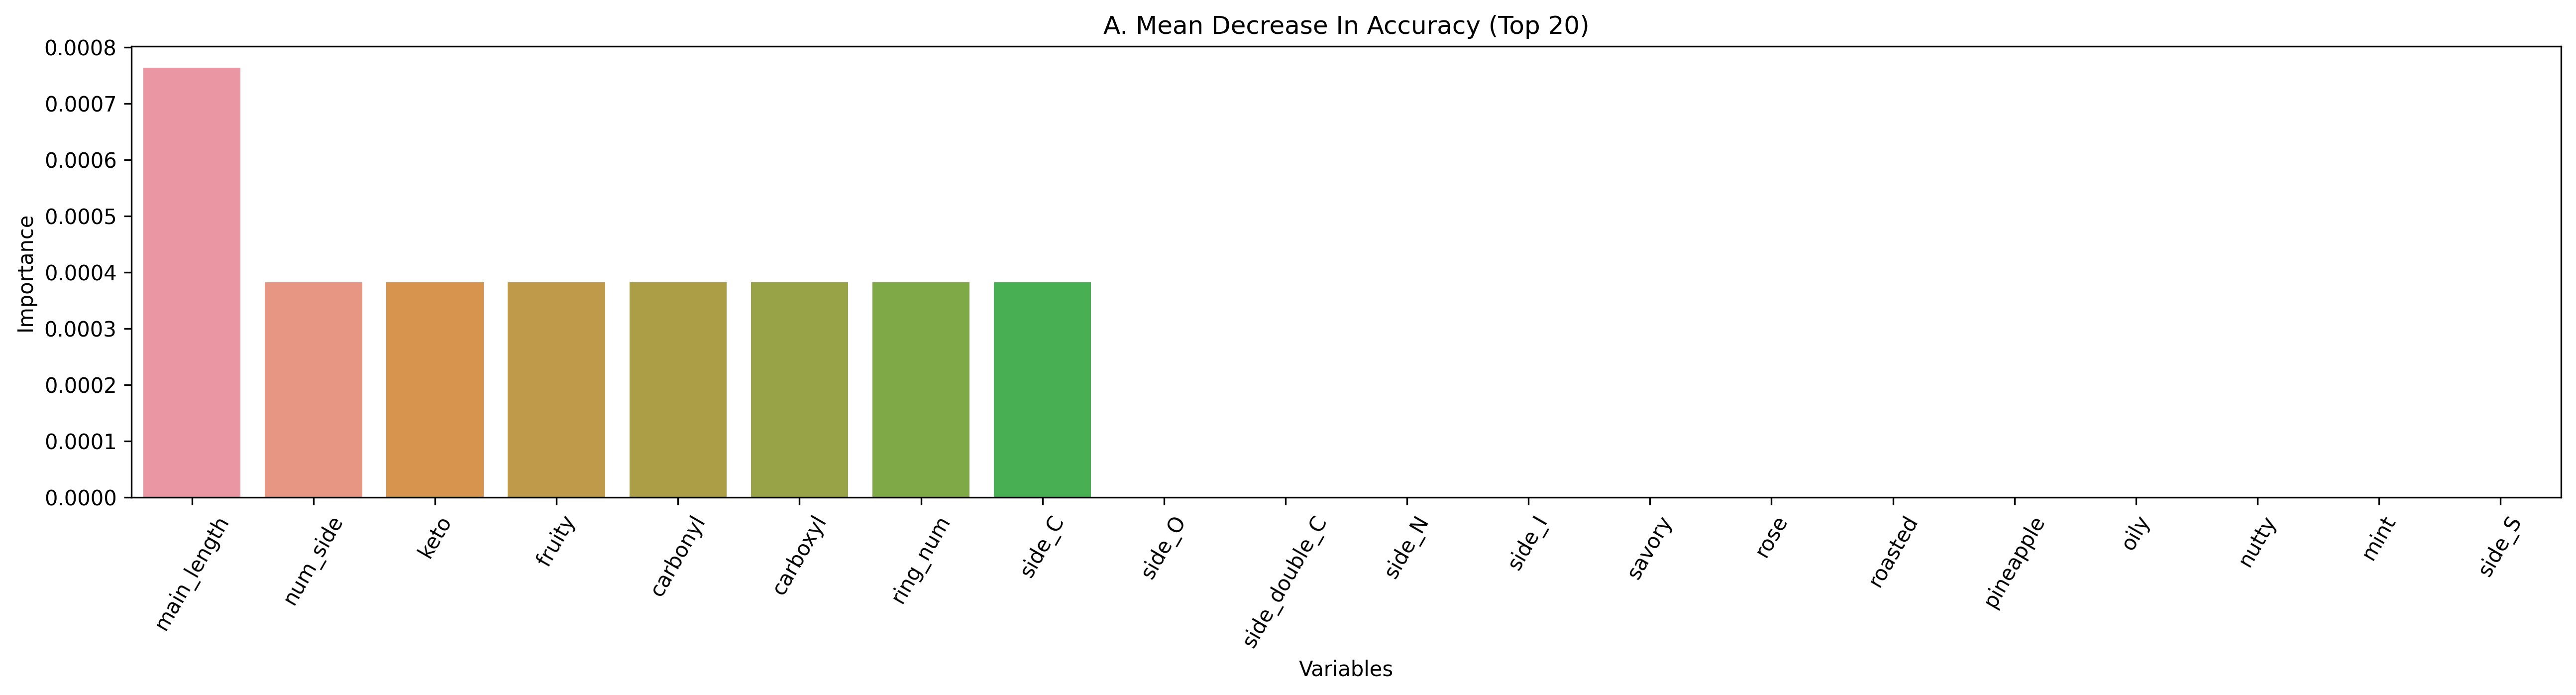

In [171]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [172]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [173]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(sweet, 4, 54)",0.042100,sweet,4,54
1,"(cheesy, 4, 9)",0.039642,cheesy,4,9
2,"(side_O, 1, 46)",0.020870,side_O,1,46
3,"(floral, 4, 14)",0.019414,floral,4,14
4,"(waxy, 4, 59)",0.013618,waxy,4,59


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

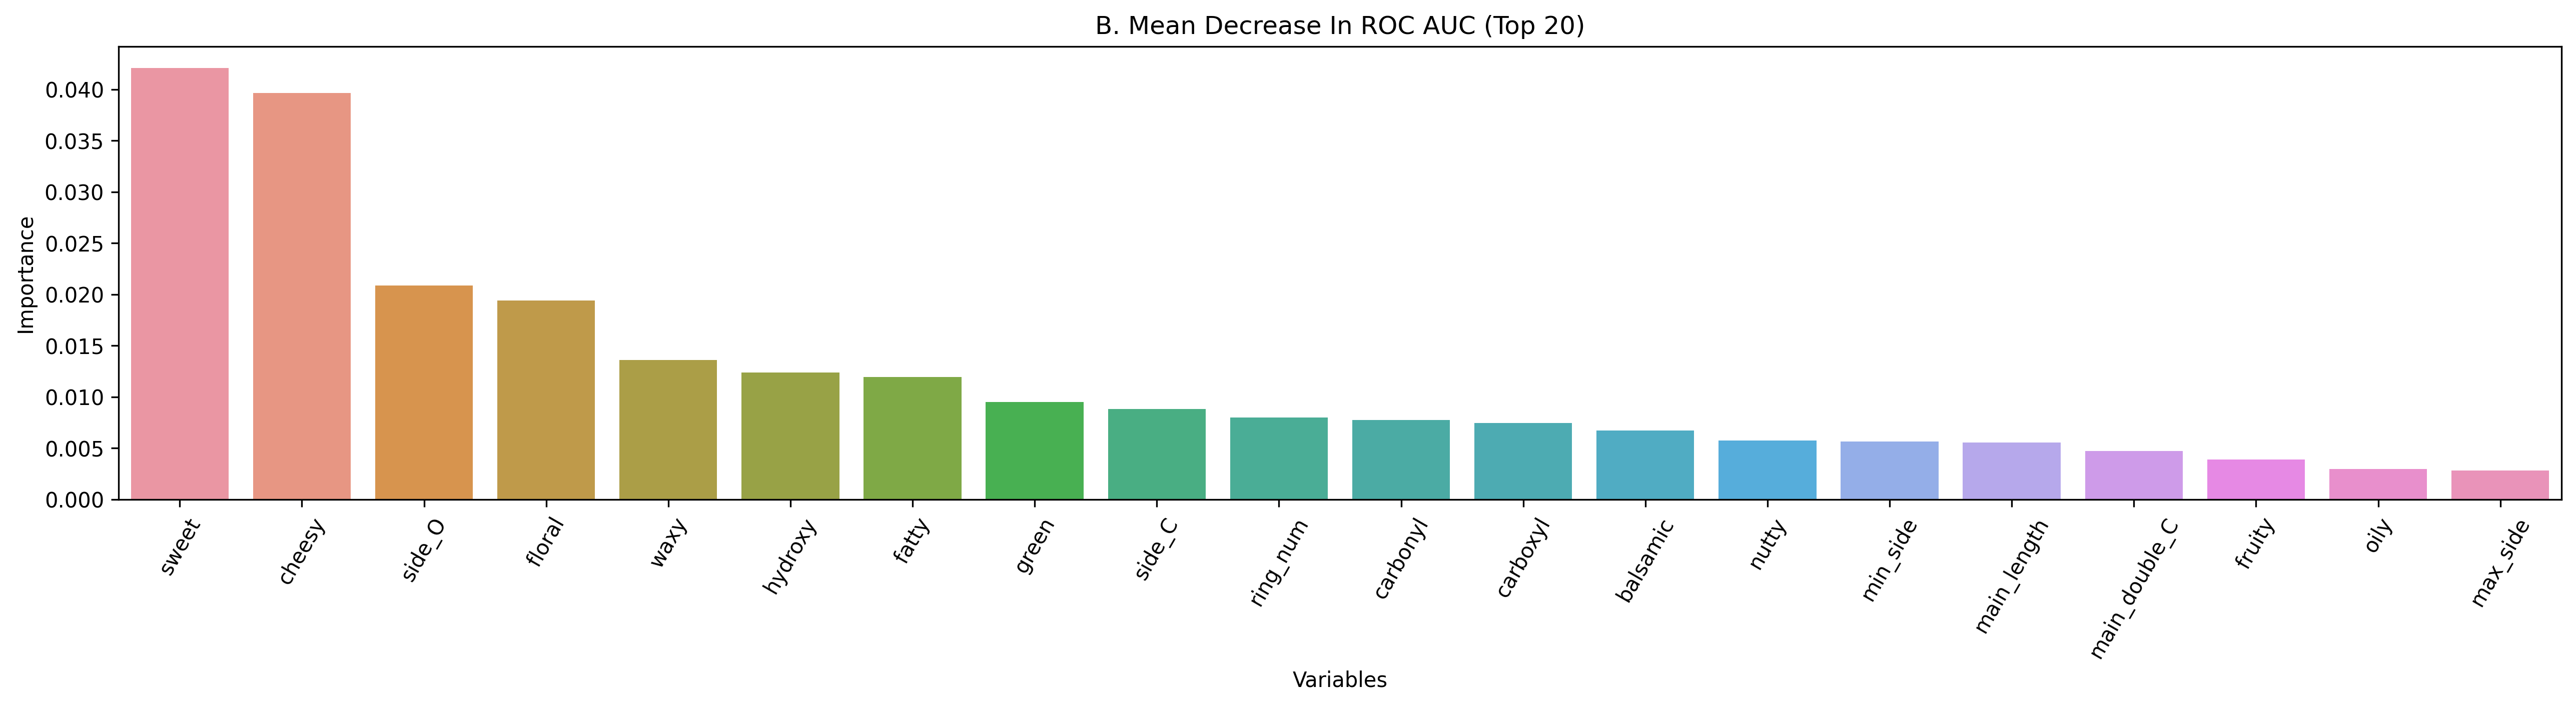

In [174]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [175]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [176]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(cheesy, 4, 9)",49.0,cheesy,4,9
1,"(fatty, 4, 13)",39.0,fatty,4,13
2,"(sweet, 4, 54)",31.0,sweet,4,54
3,"(waxy, 4, 59)",22.0,waxy,4,59
4,"(side_double_O, 1, 50)",21.0,side_double_O,1,50


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

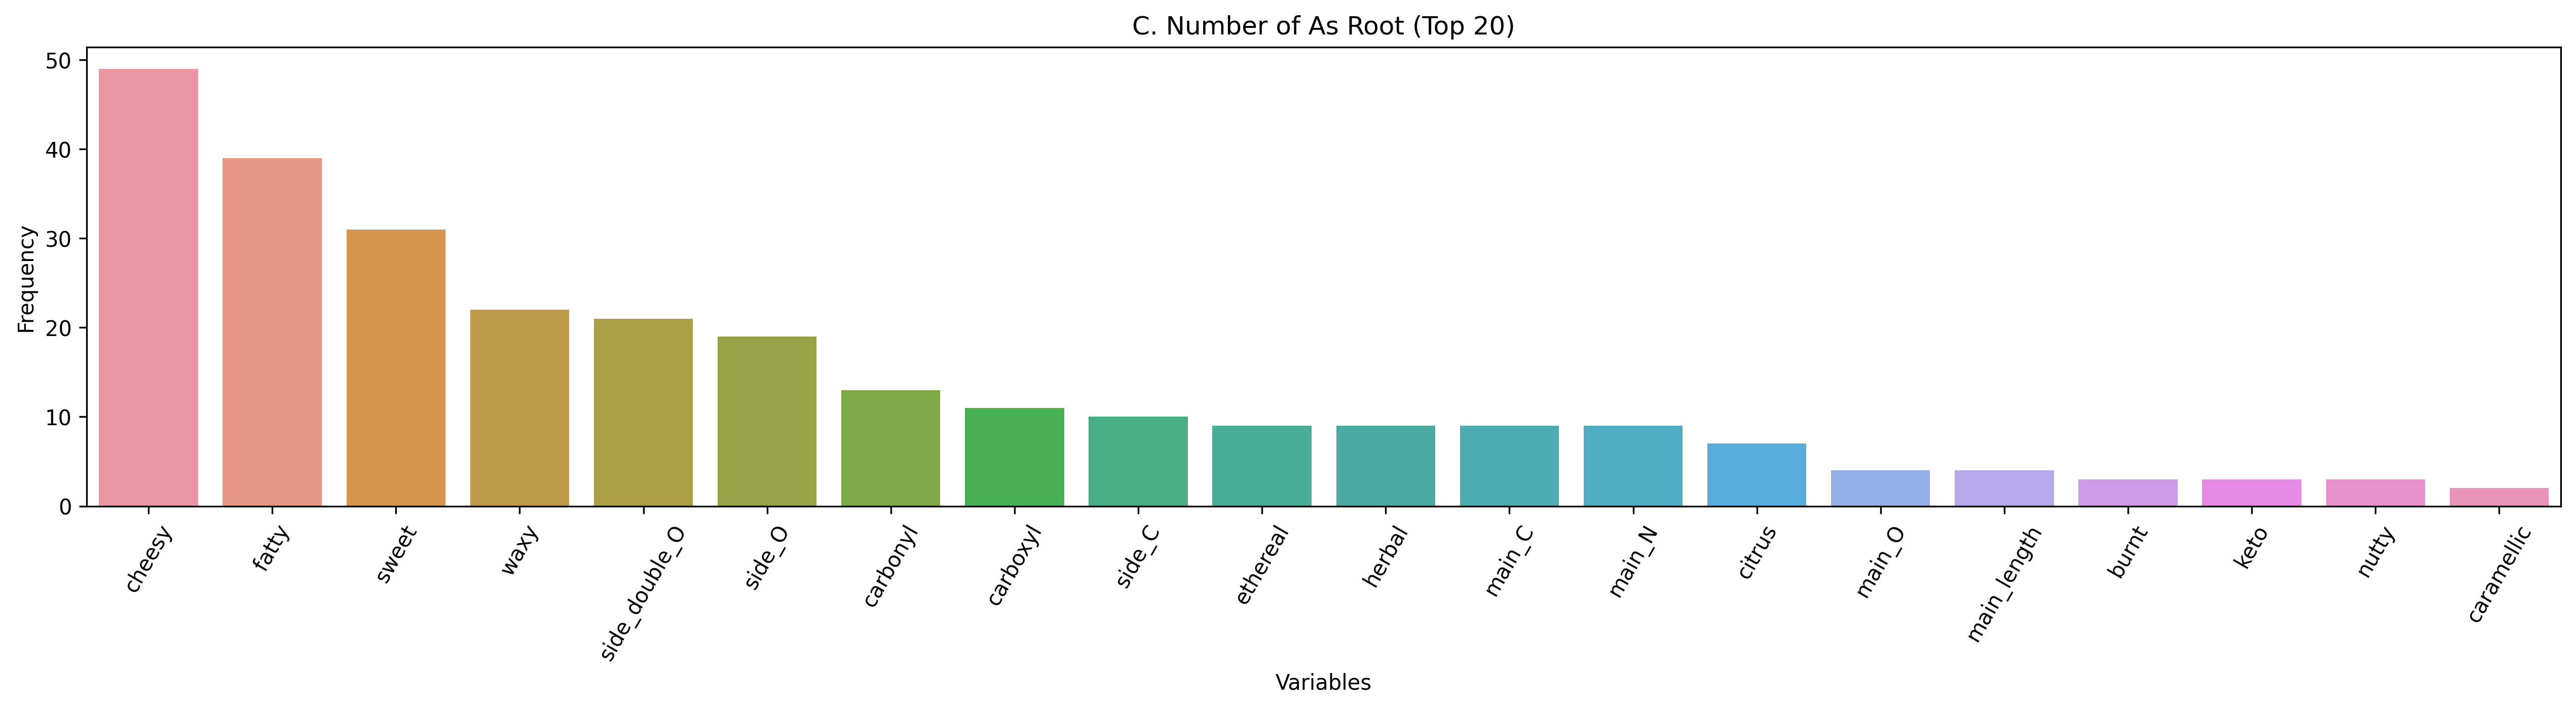

In [177]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [178]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [179]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(main_C, 1, 21)",7348.912828,main_C,1,21
1,"(main_length, 1, 30)",7308.218349,main_length,1,30
2,"(sweet, 4, 54)",4305.184939,sweet,4,54
3,"(side_C, 1, 43)",4130.596344,side_C,1,43
4,"(main_double_C, 1, 26)",3891.909564,main_double_C,1,26


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

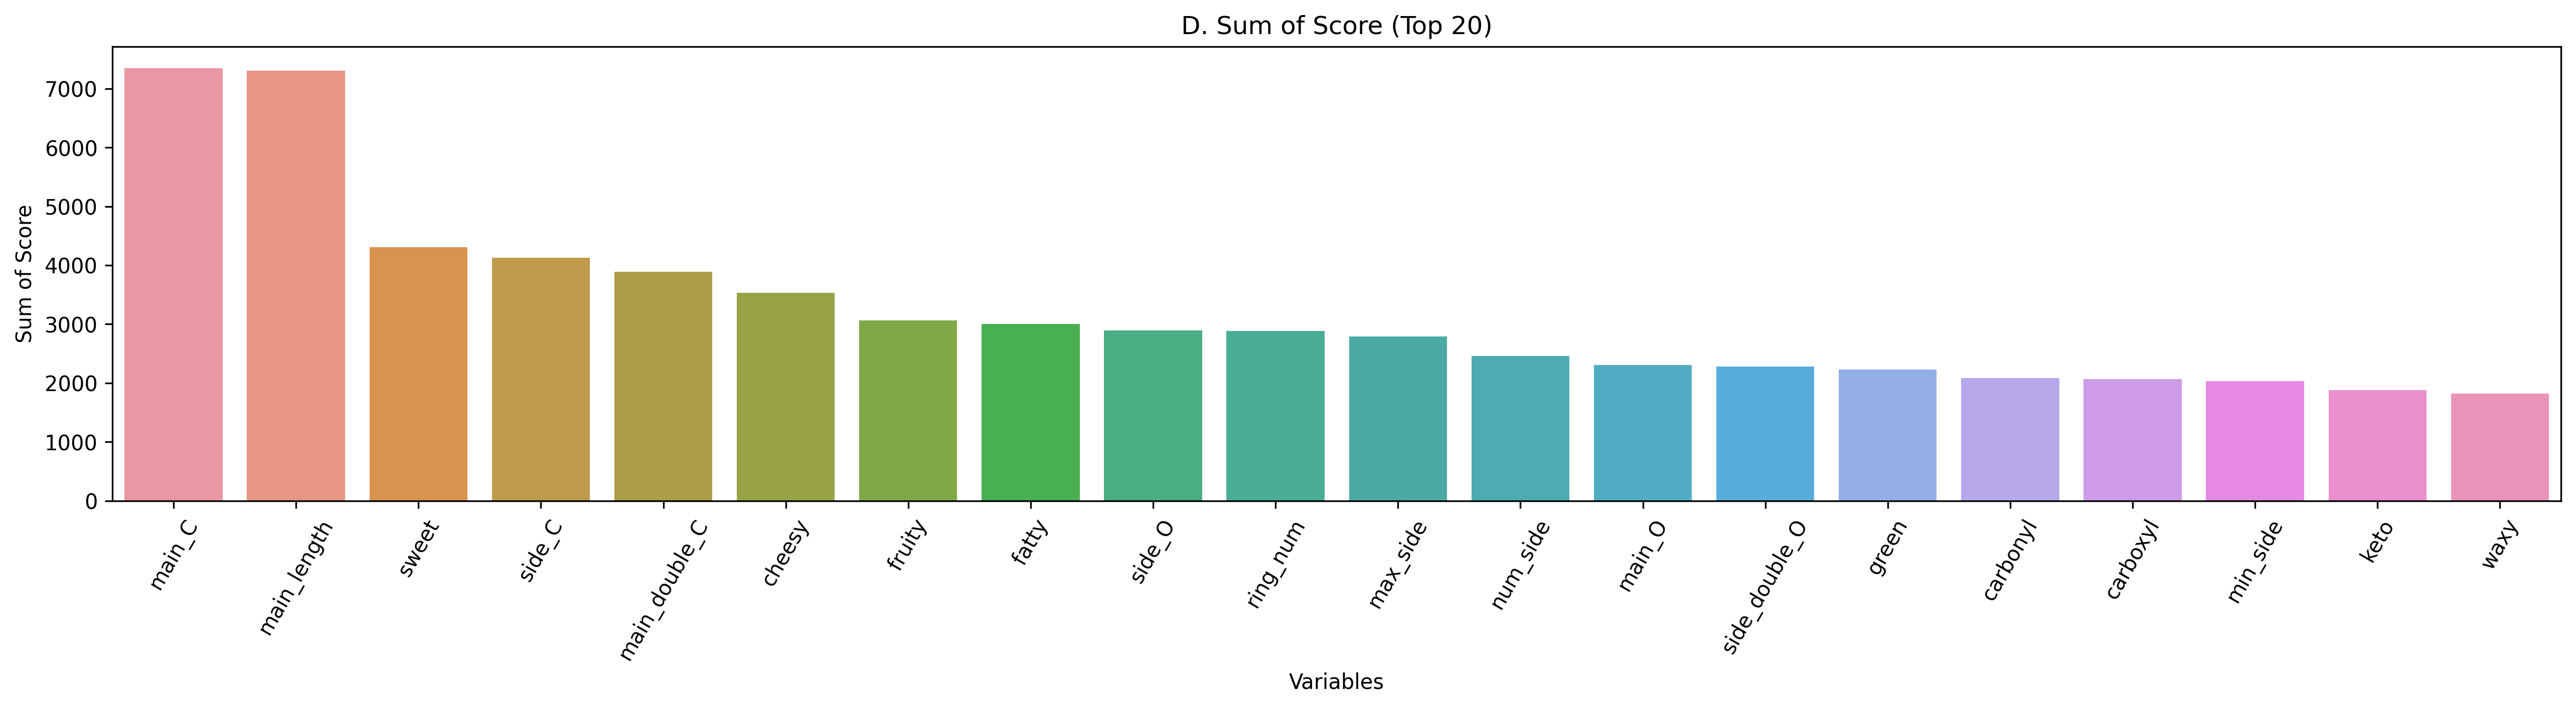

In [180]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [181]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [182]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(main_length, 1, 30)",0.000764,main_length,1,30,15,"(main_length, 1, 30)",0.005547,15.0,"(main_length, 1, 30)",4.0,1.0,"(main_length, 1, 30)",7308.218349
1,1,"(num_side, 1, 35)",0.000382,num_side,1,35,30,"(num_side, 1, 35)",0.000622,NaN,NaN,NaN,11.0,"(num_side, 1, 35)",2457.693699
2,2,"(keto, 1, 20)",0.000382,keto,1,20,23,"(keto, 1, 20)",0.001921,17.0,"(keto, 1, 20)",3.0,18.0,"(keto, 1, 20)",1880.385631
3,3,"(fruity, 4, 16)",0.000382,fruity,4,16,17,"(fruity, 4, 16)",0.003902,NaN,NaN,NaN,6.0,"(fruity, 4, 16)",3061.276767
4,4,"(carbonyl, 1, 7)",0.000382,carbonyl,1,7,10,"(carbonyl, 1, 7)",0.007755,6.0,"(carbonyl, 1, 7)",13.0,15.0,"(carbonyl, 1, 7)",2085.387135


In [183]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [184]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(10)

,variable,ranking
8,side_O,23.0
3,fruity,26.0
7,side_C,26.0
26,sweet,30.0
0,main_length,31.0
4,carbonyl,35.0
5,carboxyl,39.0
1,num_side,42.0
41,cheesy,47.0
11,side_I,53.0


# MACCS + Fragment

In [78]:
label = "creamy"

classes = MF_creamy[label].unique().tolist()
print(f"Label classes: {classes}")

MF_creamy[label] = MF_creamy[label].map(classes.index)

Label classes: [1, 0]


In [110]:
train_ds_pd, test_ds_pd = split_dataset(MF_creamy.iloc[:,3:])
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

2583 examples in training, 1153 examples for testing.


In [111]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='creamy')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='creamy')

In [112]:
# %set_cell_height 300

# Specify the model.
model_3 = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

# Optionally, add evaluation metrics.
model_3.compile(
    metrics=["accuracy","AUC","Recall","Precision"])

In [113]:
# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=train_ds)

41/41 [==============================] - 3s 22ms/step


[INFO kernel.cc:746] Start Yggdrasil model training
[INFO kernel.cc:747] Collect training examples
[INFO kernel.cc:392] Number of batches: 41
[INFO kernel.cc:393] Number of examples: 2583
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_103 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_107 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_13 (1 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:289] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column maccs_134 (1 item(s) left) because min_value_count=5 and ma

In [114]:
evaluation = model_3.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

19/19 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 0.9627 - auc: 0.8055 - recall: 0.9982 - precision: 0.9642

loss: 0.0000
accuracy: 0.9627
auc: 0.8055
recall: 0.9982
precision: 0.9642


In [115]:
inspector = model_3.make_inspector()

In [92]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 MEAN_DECREASE_IN_ACCURACY
	 MEAN_DECREASE_IN_AP_2_VS_OTHERS
	 MEAN_MIN_DEPTH
	 NUM_NODES
	 MEAN_DECREASE_IN_AUC_2_VS_OTHERS
	 SUM_SCORE
	 MEAN_DECREASE_IN_PRAUC_2_VS_OTHERS


In [116]:
mda = inspector.variable_importances()["MEAN_DECREASE_IN_ACCURACY"]
mdauc = inspector.variable_importances()["MEAN_DECREASE_IN_AUC_2_VS_OTHERS"]
nsr = inspector.variable_importances()['NUM_AS_ROOT']
ss = inspector.variable_importances()['SUM_SCORE']

In [ ]:
def RV0(series):
  return series[0]

def RV1(series):
  return series[1]

def RV2(series):
  return series[2]


### MDA MEAN DECREASE IN ACCURACY

In [117]:
mda_pd = pd.DataFrame(mda,columns=['variables','importance'])
mda_pd['variable'] = mda_pd.variables.apply(RV0)
mda_pd['type'] = mda_pd.variables.apply(RV1)
mda_pd['id'] = mda_pd.variables.apply(RV2)

In [118]:
mda_pd.head()

,variables,importance,variable,type,id
0,"(sweet, 4, 221)",0.001161,sweet,4,221
1,"(main_length, 1, 197)",0.000774,main_length,1,197
2,"(fatty, 4, 13)",0.000774,fatty,4,13
3,"(maccs_57, 4, 141)",0.000774,maccs_57,4,141
4,"(maccs_126, 4, 52)",0.000387,maccs_126,4,52


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'A. Mean Decrease In Accuracy (Top 20)')

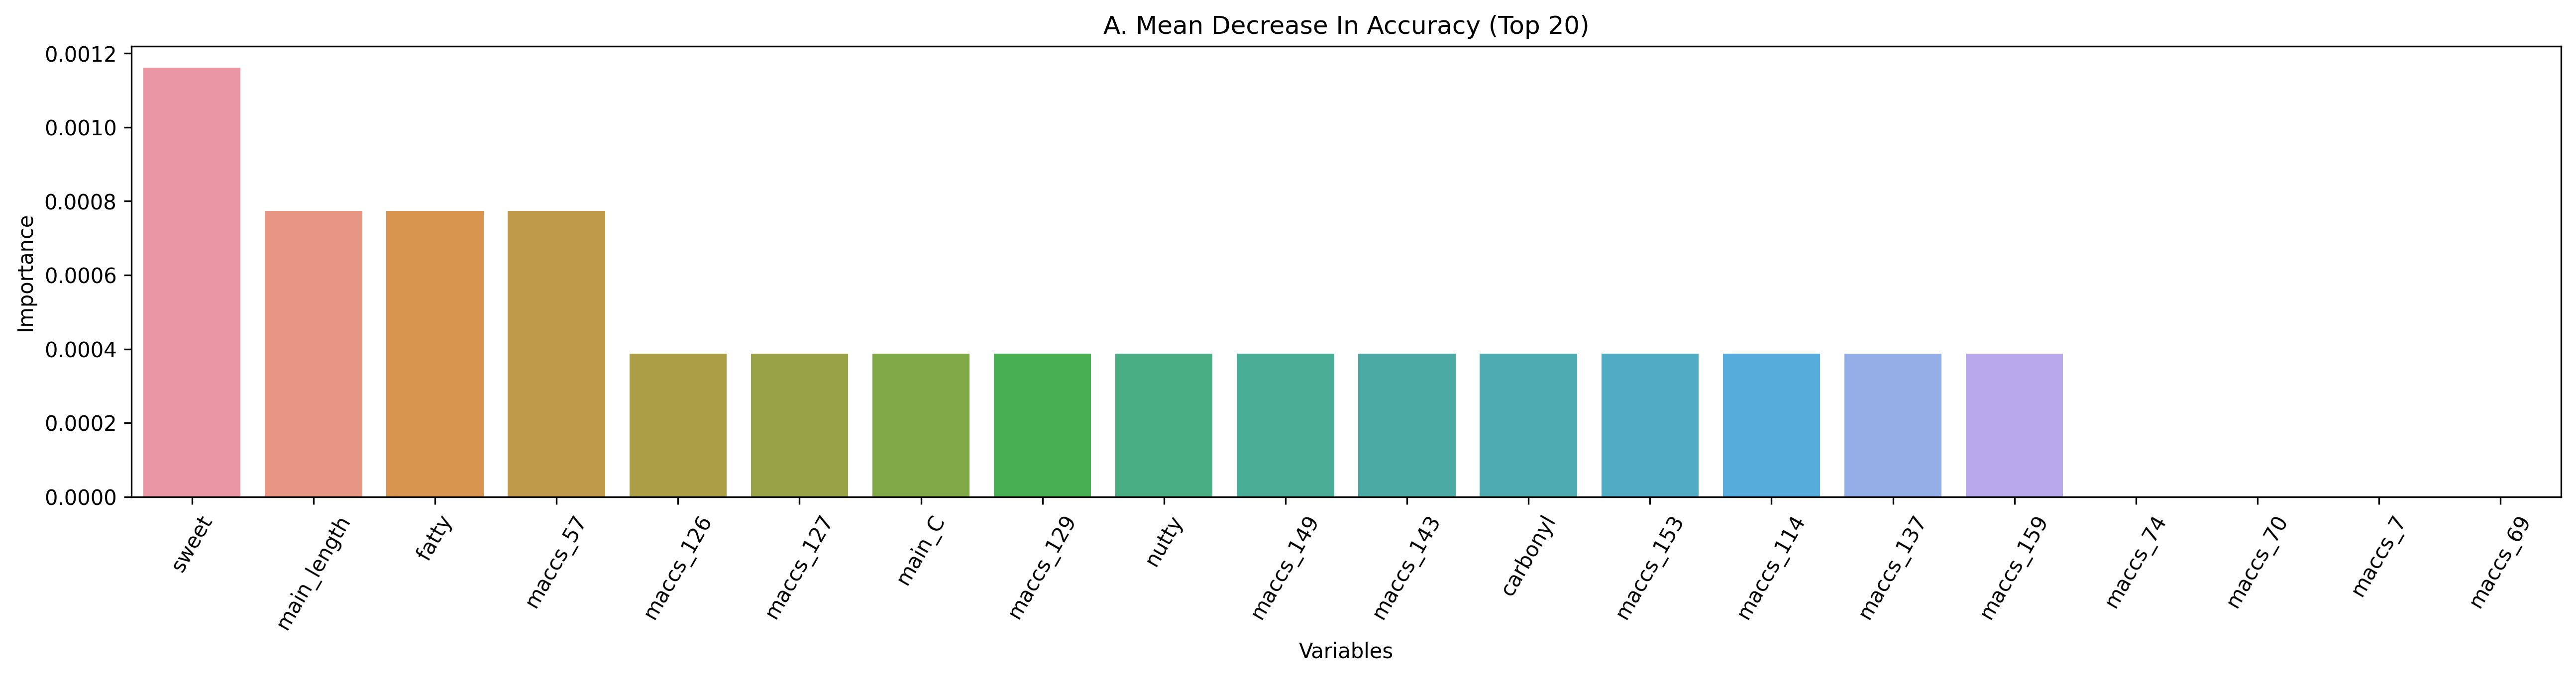

In [119]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mda_pd['variable'][:20], mda_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('A. Mean Decrease In Accuracy (Top 20)')

### MDAUC MEAN_DECREASE_IN_AUC_2_VS_OTHERS

In [120]:
mdauc_pd = pd.DataFrame(mdauc,columns=['variables','importance'])
mdauc_pd['variable'] = mdauc_pd.variables.apply(RV0)
mdauc_pd['type'] = mdauc_pd.variables.apply(RV1)
mdauc_pd['id'] = mdauc_pd.variables.apply(RV2)

In [121]:
mdauc_pd.head()

,variables,importance,variable,type,id
0,"(maccs_72, 4, 158)",0.027046,maccs_72,4,158
1,"(cheesy, 4, 9)",0.026286,cheesy,4,9
2,"(waxy, 4, 226)",0.016062,waxy,4,226
3,"(fatty, 4, 13)",0.013616,fatty,4,13
4,"(maccs_149, 4, 77)",0.012499,maccs_149,4,77


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'B. Mean Decrease In ROC AUC (Top 20)')

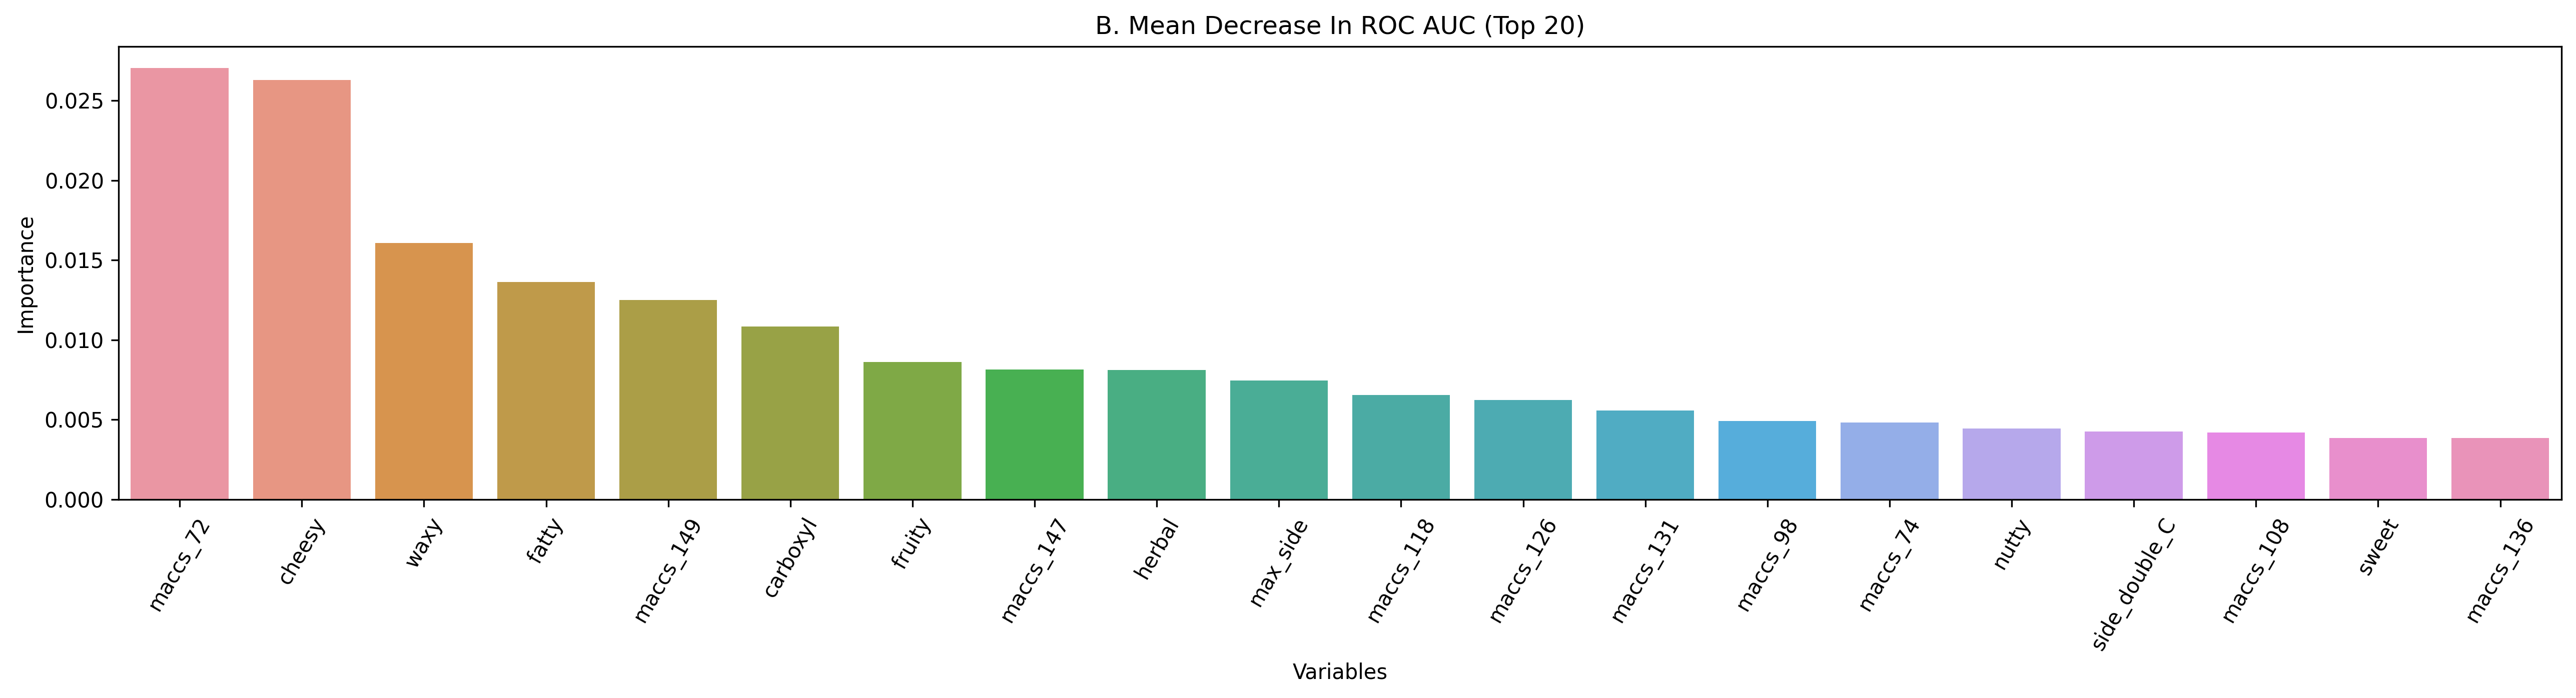

In [122]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(mdauc_pd['variable'][:20], mdauc_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Importance')

plt.title('B. Mean Decrease In ROC AUC (Top 20)')

### NSR NUM_AS_ROOT

In [123]:
nsr_pd = pd.DataFrame(nsr,columns=['variables','importance'])
nsr_pd['variable'] = nsr_pd.variables.apply(RV0)
nsr_pd['type'] = nsr_pd.variables.apply(RV1)
nsr_pd['id'] = nsr_pd.variables.apply(RV2)

In [124]:
nsr_pd.head()

,variables,importance,variable,type,id
0,"(maccs_57, 4, 141)",31.0,maccs_57,4,141
1,"(maccs_159, 4, 88)",18.0,maccs_159,4,88
2,"(maccs_98, 4, 186)",17.0,maccs_98,4,186
3,"(maccs_143, 4, 71)",16.0,maccs_143,4,71
4,"(maccs_72, 4, 158)",16.0,maccs_72,4,158


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'C. Number of As Root (Top 20)')

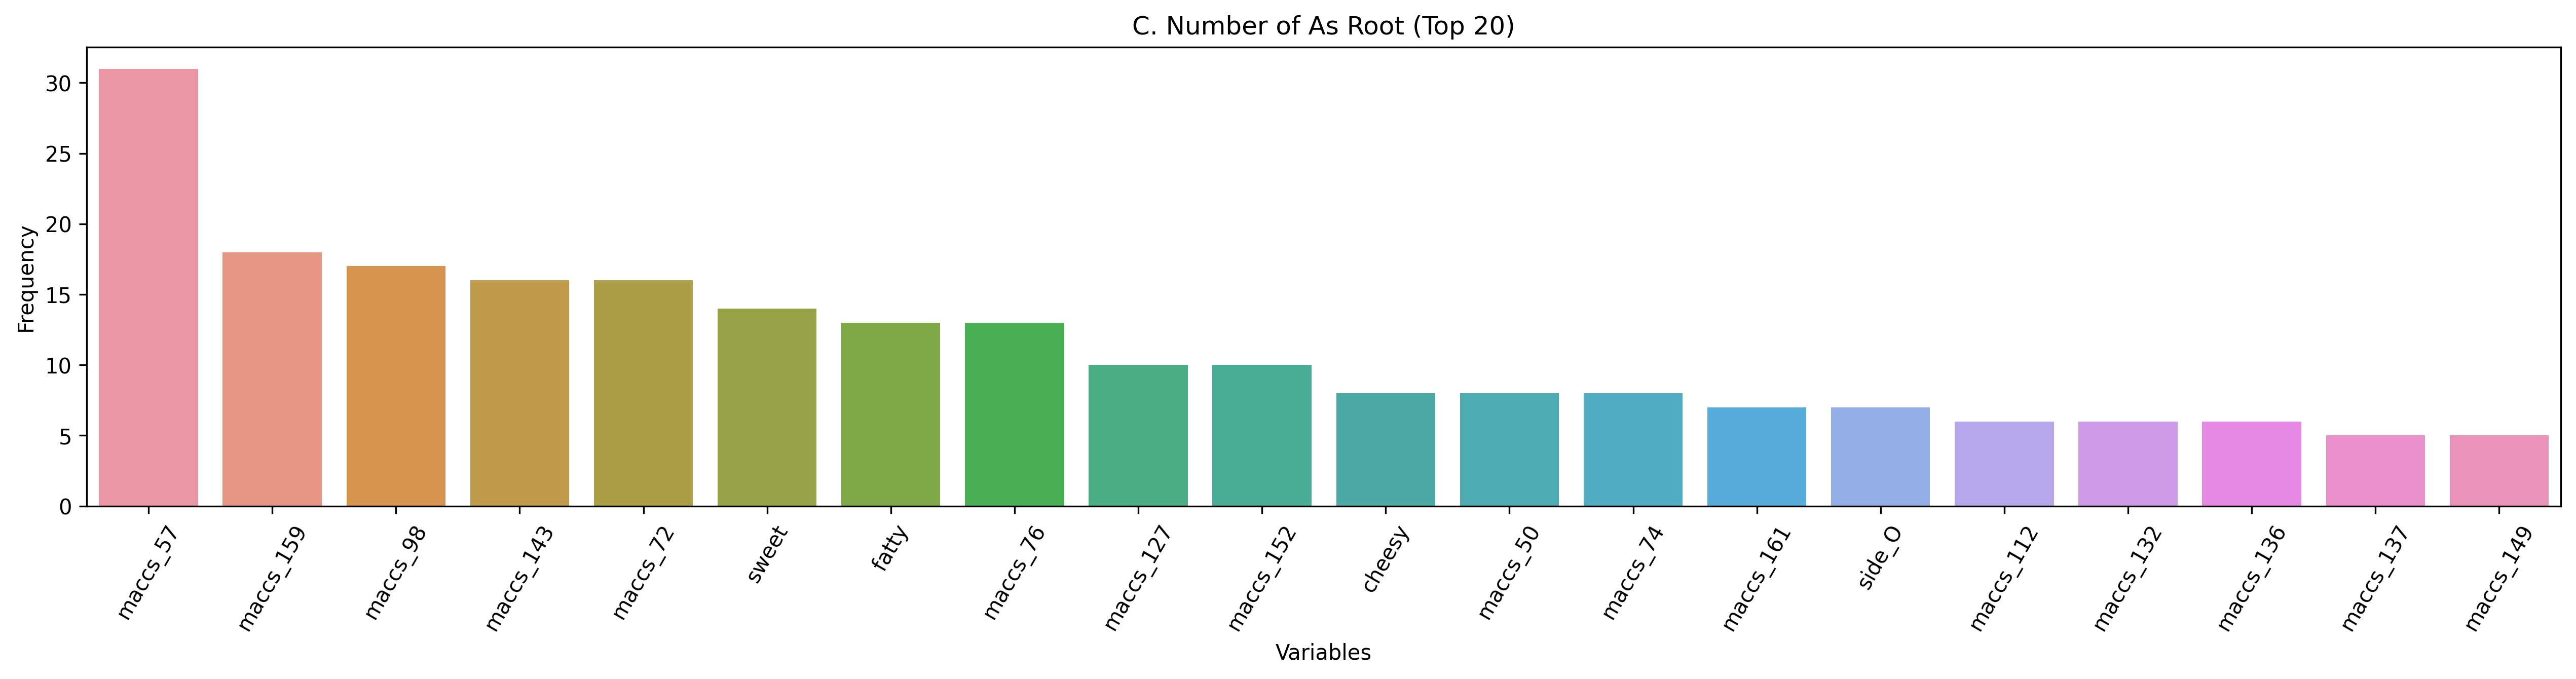

In [125]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(nsr_pd['variable'][:20], nsr_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Frequency')

plt.title('C. Number of As Root (Top 20)')

### SS SUM OF SCORE

In [126]:
ss_pd = pd.DataFrame(ss,columns=['variables','importance'])
ss_pd['variable'] = ss_pd.variables.apply(RV0)
ss_pd['type'] = ss_pd.variables.apply(RV1)
ss_pd['id'] = ss_pd.variables.apply(RV2)

In [127]:
ss_pd.head()

,variables,importance,variable,type,id
0,"(main_C, 1, 188)",4833.637730,main_C,1,188
1,"(main_length, 1, 197)",4341.743543,main_length,1,197
2,"(sweet, 4, 221)",3821.773117,sweet,4,221
3,"(maccs_57, 4, 141)",2515.714586,maccs_57,4,141
4,"(maccs_72, 4, 158)",2466.390730,maccs_72,4,158


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'D. Sum of Score (Top 20)')

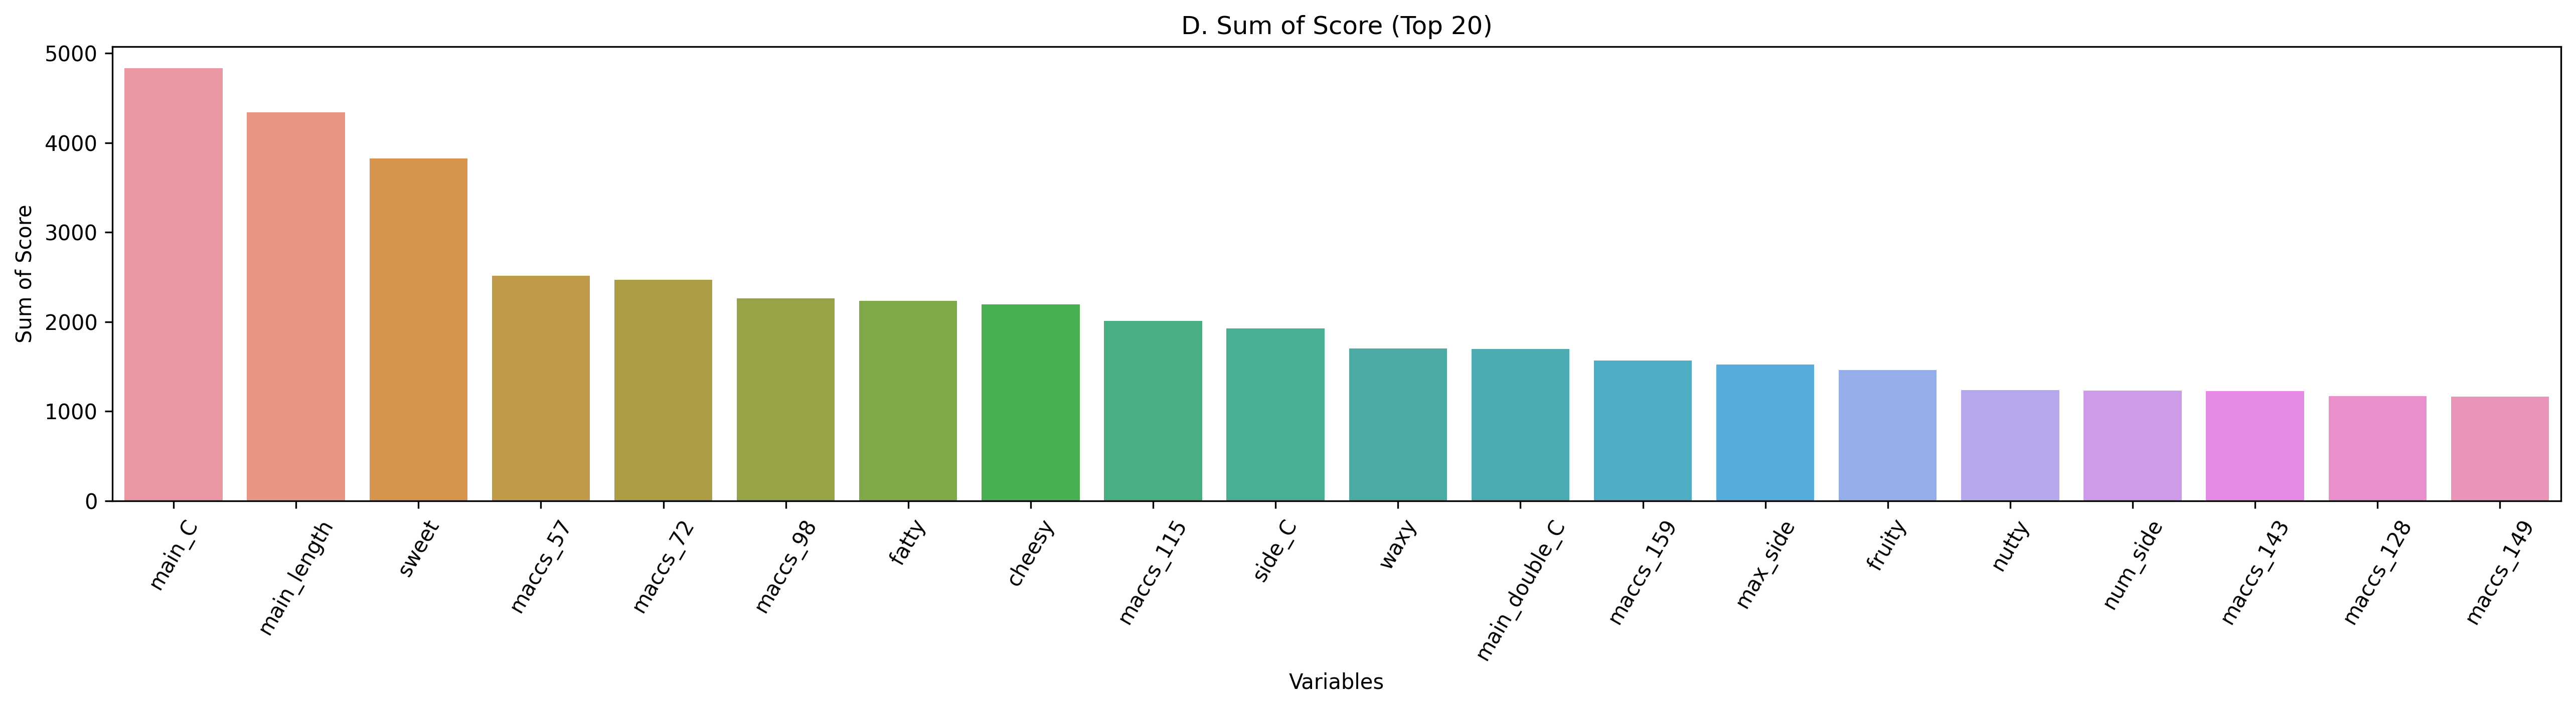

In [128]:
plt.figure(dpi=300,figsize=(21,4))
# sns.set(dpi=300,rc={"figure.figsize": (21, 4)})
sns.barplot(ss_pd['variable'][:20], ss_pd['importance'][:20])
plt.xticks(rotation=60)
plt.xlabel('Variables')
plt.ylabel('Sum of Score')

plt.title('D. Sum of Score (Top 20)')

### Overall Summary


In [129]:
mda_pd.reset_index(inplace=True)
mdauc_pd.reset_index(inplace=True)
nsr_pd.reset_index(inplace=True)
ss_pd.reset_index(inplace=True)

In [130]:
df0 = pd.merge(mda_pd,mdauc_pd,on=['variable','type',	'id'],how='outer')
df1 = pd.merge(df0,nsr_pd,on=['variable','type',	'id'],how='outer')
df2 = pd.merge(df1,ss_pd,on=['variable','type',	'id'],how='outer')
df2.head()

,index_x,variables_x,importance_x,variable,type,id,index_y,variables_y,importance_y,index_x,variables_x,importance_x,index_y,variables_y,importance_y
0,0,"(sweet, 4, 221)",0.001161,sweet,4,221,18,"(sweet, 4, 221)",0.003863,5.0,"(sweet, 4, 221)",14.0,2.0,"(sweet, 4, 221)",3821.773117
1,1,"(main_length, 1, 197)",0.000774,main_length,1,197,41,"(main_length, 1, 197)",0.001220,24.0,"(main_length, 1, 197)",4.0,1.0,"(main_length, 1, 197)",4341.743543
2,2,"(fatty, 4, 13)",0.000774,fatty,4,13,3,"(fatty, 4, 13)",0.013616,6.0,"(fatty, 4, 13)",13.0,6.0,"(fatty, 4, 13)",2233.597948
3,3,"(maccs_57, 4, 141)",0.000774,maccs_57,4,141,213,"(maccs_57, 4, 141)",-0.002947,0.0,"(maccs_57, 4, 141)",31.0,3.0,"(maccs_57, 4, 141)",2515.714586
4,4,"(maccs_126, 4, 52)",0.000387,maccs_126,4,52,11,"(maccs_126, 4, 52)",0.006246,NaN,NaN,NaN,21.0,"(maccs_126, 4, 52)",1149.907162


In [131]:
df2['ranking'] = df2[['index_x','index_y']].sum(axis=1)

In [132]:
df2.sort_values(by=['ranking'],ascending=True)[['variable','ranking']].head(20)

,variable,ranking
2,fatty,17.0
0,sweet,25.0
24,maccs_72,32.0
4,maccs_126,36.0
9,maccs_149,51.0
15,maccs_159,56.0
8,nutty,59.0
10,maccs_143,64.0
1,main_length,67.0
16,maccs_74,85.0
